/home/mohammad/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2025-03-09 04:30:26.991049: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-03-09 04:30:26.991123: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Augmenting training data for balancing...
Fixed time series length from training data: 280
Total number of batches: 6837
Number of low batches (t5 < 3.5): 2277
Number of normal batches (3.5 <= t5 <= 5.0): 2280
Number of high batches (t5 > 5.0): 2280

Total number of batches: 695
Number of low batches (t5 < 3.5): 162
Number of normal batches (3.5 <= t5 <= 5.0): 493
Number of high batches (t5 > 5.0): 40

Total number of batches: 695
Number of low batches (t5 < 3.5): 162
Number of normal batches (3.5 <= t5 <= 5.0): 506
Number of high batches (t5 > 5.0): 27

Number of training data points: 6837
Number of validation data points: 695
Number of test data points: 695


2025-03-09 04:32:48.011697: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-03-09 04:32:48.011727: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-03-09 04:32:48.011755: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2025-03-09 04:32:48.012078: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
214/214 [==============================] - 42s 181ms/step - loss: 2.1247 - mae: 1.1396 - val_loss: 0.5117 - val_mae: 0.5603
Epoch 2/50
214/214 [==============================] - 38s 178ms/step - loss: 0.9789 - mae: 0.8553 - val_loss: 0.4010 - val_mae: 0.4900
Epoch 3/50
214/214 [==============================] - 37s 173ms/step - loss: 0.7268 - mae: 0.7222 - val_loss: 0.2878 - val_mae: 0.4038
Epoch 4/50
214/214 [==============================] - 37s 173ms/step - loss: 0.4854 - mae: 0.5572 - val_loss: 0.2735 - val_mae: 0.3873
Epoch 5/50
214/214 [==============================] - 37s 173ms/step - loss: 0.3905 - mae: 0.4709 - val_loss: 0.2896 - val_mae: 0.4003
Epoch 6/50
214/214 [==============================] - 42s 196ms/step - loss: 0.3404 - mae: 0.4310 - val_loss: 0.2594 - val_mae: 0.3740
Epoch 7/50
214/214 [==============================] - 43s 199ms/step - loss: 0.3012 - mae: 0.4000 - val_loss: 0.2350 - val_mae: 0.3574
Epoch 8/50
214/214 [==============================] - 4

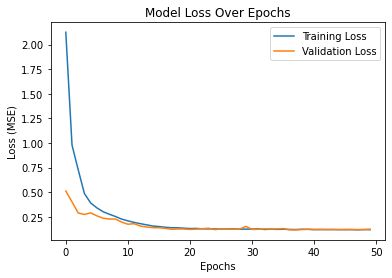

Training Set - Loss (MSE): 0.1176, MAE: 0.2227
Validation Set - Loss (MSE): 0.1236, MAE: 0.2500
Test Set - Loss (MSE): 0.1805, MAE: 0.2477
--- Training Set ---
Low: MAE = 0.2233, Accuracy = 85.02%
Normal: MAE = 0.2546, Accuracy = 84.17%
High: MAE = 0.1902, Accuracy = 93.99%
--- Validation Set ---
Low: MAE = 0.2382, Accuracy = 80.86%
Normal: MAE = 0.2584, Accuracy = 82.76%
High: MAE = 0.1937, Accuracy = 85.00%
--- Test Set ---
Low: MAE = 0.2677, Accuracy = 80.25%
Normal: MAE = 0.2382, Accuracy = 84.98%
High: MAE = 0.3061, Accuracy = 85.19%
Class Distribution for Training Set:
normal    2280
high      2280
low       2277
dtype: int64
Percentage:
normal    33.347960
high      33.347960
low       33.304081
dtype: float64

Class Distribution for Validation Set:
normal    493
low       162
high       40
dtype: int64
Percentage:
normal    70.935252
low       23.309353
high       5.755396
dtype: float64

Class Distribution for Test Set:
normal    506
low       162
high       27
dtype: int64
Pe

In [1]:
from bounds import bounds
import matplotlib.pyplot as plt
import numpy as np
import ast
import pandas as pd
from cooper_standard import CooperStandard
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Concatenate
from sklearn.model_selection import train_test_split

# ============================================================
# Configuration flag: Set to True to augment training data,
# or False to use the original training data.
USE_AUGMENTATION = True
# ============================================================

# %% Setup and Data Loading
file_path = "DataOn2025Jan08.xlsx"
sheet_names = ["NES2060C05Line2", "NES2060C06Line2"]
variables = [
    "batch_number", "MDRTorqueS1", "MDRTorqueS2", 
    "mh", "ml", "TimeAtML", "TimeAtML_min", "ml_min",
    "start_time", "end_time", "t5"
]

# Instantiate the CooperStandard class and load data
cooper_standard = CooperStandard(file_path, sheet_names, variables)
df_all = cooper_standard.load_data()
cleaned_df, removed_batches = cooper_standard.preprocessing(280)

# Set lower and upper bounds for t5 (from your bounds dictionary)
lb, ub = bounds["2060C05"][0], bounds["2060C05"][1]

# %% Split the Original DataFrame into Training, Validation, and Test Sets
# (We do this before augmentation so that only the training data gets augmented.)
train_df, temp_df = train_test_split(cleaned_df, train_size=0.7, random_state=42)
val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)

if USE_AUGMENTATION:
    print("Augmenting training data for balancing...")
    # Augment only the training set using the SMOTE-like method.
    train_df = cooper_standard.balance_data_with_synthetic(train_df, lb, ub, k=5)
else:
    print("Using original training data without augmentation.")

# %% Convert DataFrames to Dictionary Format (before normalization)
# train_dict = cooper_standard.convert_to_dict(train_df)
# val_dict = cooper_standard.convert_to_dict(val_df)
# test_dict = cooper_standard.convert_to_dict(test_df)
# Convert the training set to dictionary and determine the fixed length from training data.
train_dict = cooper_standard.convert_to_dict(train_df)
# Assume training set is non-empty; get fixed_length from one training sample.
fixed_length = list(train_dict.values())[0]["time_series"].shape[0]
print("Fixed time series length from training data:", fixed_length)

# Convert validation and test sets using the fixed_length.
val_dict = cooper_standard.convert_to_dict(val_df, fixed_length=fixed_length)
test_dict = cooper_standard.convert_to_dict(test_df, fixed_length=fixed_length)


# %% Normalize the Data Using Training Statistics
# (Normalization is applied after augmentation.)
train_dict_norm = cooper_standard.normalize_data(train_dict, fit=True)
val_dict_norm = cooper_standard.normalize_data(val_dict, fit=False)
test_dict_norm = cooper_standard.normalize_data(test_dict, fit=False)

# Print t5 categories for each split to verify balancing
cooper_standard.print_t5_categories(train_dict_norm, lb, ub)
cooper_standard.print_t5_categories(val_dict_norm, lb, ub)
cooper_standard.print_t5_categories(test_dict_norm, lb, ub)

print(f"Number of training data points: {len(train_dict_norm)}")
print(f"Number of validation data points: {len(val_dict_norm)}")
print(f"Number of test data points: {len(test_dict_norm)}")

# %% Prepare Data for Model Training
def prepare_data_from_dict(data_dict):
    # Extract time series, scalar features, and targets from the dictionary
    time_series = np.array([batch["time_series"] for batch in data_dict.values()])
    scalar_features = np.array([batch["scalar_features"] for batch in data_dict.values()])
    targets = np.array([batch["t5"] for batch in data_dict.values()])
    return time_series, scalar_features, targets

train_ts, train_scalar, train_targets = prepare_data_from_dict(train_dict_norm)
val_ts, val_scalar, val_targets = prepare_data_from_dict(val_dict_norm)
test_ts, test_scalar, test_targets = prepare_data_from_dict(test_dict_norm)

# %% Build the Neural Network Model
sequence_length = train_ts.shape[1]  # e.g., number of time steps (280)
num_scalar_features = train_scalar.shape[1]  # e.g., 6 scalar features

# Time series branch (using LSTM)
ts_input = Input(shape=(sequence_length, 4), name='time_series_input')
lstm_out = LSTM(units=64)(ts_input)

# Scalar features branch (using Dense layer)
scalar_input = Input(shape=(num_scalar_features,), name='scalar_input')
scalar_dense = Dense(16, activation='relu')(scalar_input)

# Combine both branches
combined = Concatenate()([lstm_out, scalar_dense])
dense = Dense(32, activation='relu')(combined)
output = Dense(1, name='t5_output')(dense)  # Regression output for t5

model = Model(inputs=[ts_input, scalar_input], outputs=output)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# %% Train the Model
history = model.fit(
    [train_ts, train_scalar], train_targets,
    validation_data=([val_ts, val_scalar], val_targets),
    epochs=50,
    batch_size=32,
    verbose=1
)

# %% Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# %% Evaluate the Model on All Sets
train_loss, train_mae = model.evaluate([train_ts, train_scalar], train_targets, verbose=0)
print(f"Training Set - Loss (MSE): {train_loss:.4f}, MAE: {train_mae:.4f}")
val_loss, val_mae = model.evaluate([val_ts, val_scalar], val_targets, verbose=0)
print(f"Validation Set - Loss (MSE): {val_loss:.4f}, MAE: {val_mae:.4f}")
test_loss, test_mae = model.evaluate([test_ts, test_scalar], test_targets, verbose=0)
print(f"Test Set - Loss (MSE): {test_loss:.4f}, MAE: {test_mae:.4f}")

# %% Make Predictions
train_pred = model.predict([train_ts, train_scalar]).flatten()
val_pred = model.predict([val_ts, val_scalar]).flatten()
test_pred = model.predict([test_ts, test_scalar]).flatten()

# %% Compute and Print Class Metrics
def compute_class_metrics(true_t5, pred_t5, lb, ub):
    # Define masks for each t5 region
    low_mask = true_t5 < lb
    normal_mask = (true_t5 >= lb) & (true_t5 <= ub)
    high_mask = true_t5 > ub
    
    def get_metrics(mask, pred_condition):
        if np.sum(mask) == 0:
            return np.nan, np.nan
        mae = np.mean(np.abs(true_t5[mask] - pred_t5[mask]))
        accuracy = np.mean(pred_condition[mask]) * 100  # simple placeholder metric
        return mae, accuracy

    low_mae, low_acc = get_metrics(low_mask, pred_t5 < lb)
    normal_mae, normal_acc = get_metrics(normal_mask, (pred_t5 >= lb) & (pred_t5 <= ub))
    high_mae, high_acc = get_metrics(high_mask, pred_t5 > ub)
    
    return {
        'low': {'mae': low_mae, 'accuracy': low_acc},
        'normal': {'mae': normal_mae, 'accuracy': normal_acc},
        'high': {'mae': high_mae, 'accuracy': high_acc}
    }

def print_metrics(metrics, dataset_name):
    print(f"--- {dataset_name} ---")
    for cls in ['low', 'normal', 'high']:
        mae = metrics[cls]['mae']
        acc = metrics[cls]['accuracy']
        if np.isnan(mae):
            print(f"{cls.capitalize()}: No data points")
        else:
            print(f"{cls.capitalize()}: MAE = {mae:.4f}, Accuracy = {acc:.2f}%")

train_metrics = compute_class_metrics(train_targets, train_pred, lb, ub)
val_metrics = compute_class_metrics(val_targets, val_pred, lb, ub)
test_metrics = compute_class_metrics(test_targets, test_pred, lb, ub)

print_metrics(train_metrics, "Training Set")
print_metrics(val_metrics, "Validation Set")
print_metrics(test_metrics, "Test Set")

# %% Additional Analysis: Class Distribution
def categorize_t5(t5):
    if t5 < lb:
        return 'low'
    elif lb <= t5 <= ub:
        return 'normal'
    else:
        return 'high'

def analyze_class_distribution(targets, dataset_name):
    classes = [categorize_t5(t) for t in targets]
    class_counts = pd.Series(classes).value_counts()
    print(f"Class Distribution for {dataset_name}:")
    print(class_counts)
    print(f"Percentage:\n{class_counts / len(targets) * 100}\n")

analyze_class_distribution(train_targets, "Training Set")
analyze_class_distribution(val_targets, "Validation Set")
analyze_class_distribution(test_targets, "Test Set")